In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import cv2
from os.path import join, exists, isdir
from pathlib import Path
import random
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.util import random_noise
import skimage.io

In [24]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

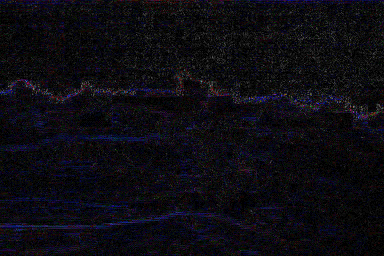

In [25]:
path='/kaggle/input/casiav2revised/CASIA2.0_revised/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
quality=91
convert_to_ela_image(path, quality)

In [26]:
def compute_ela_cv(path, quality):
    temp_filename = '/kaggle/working/temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [27]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

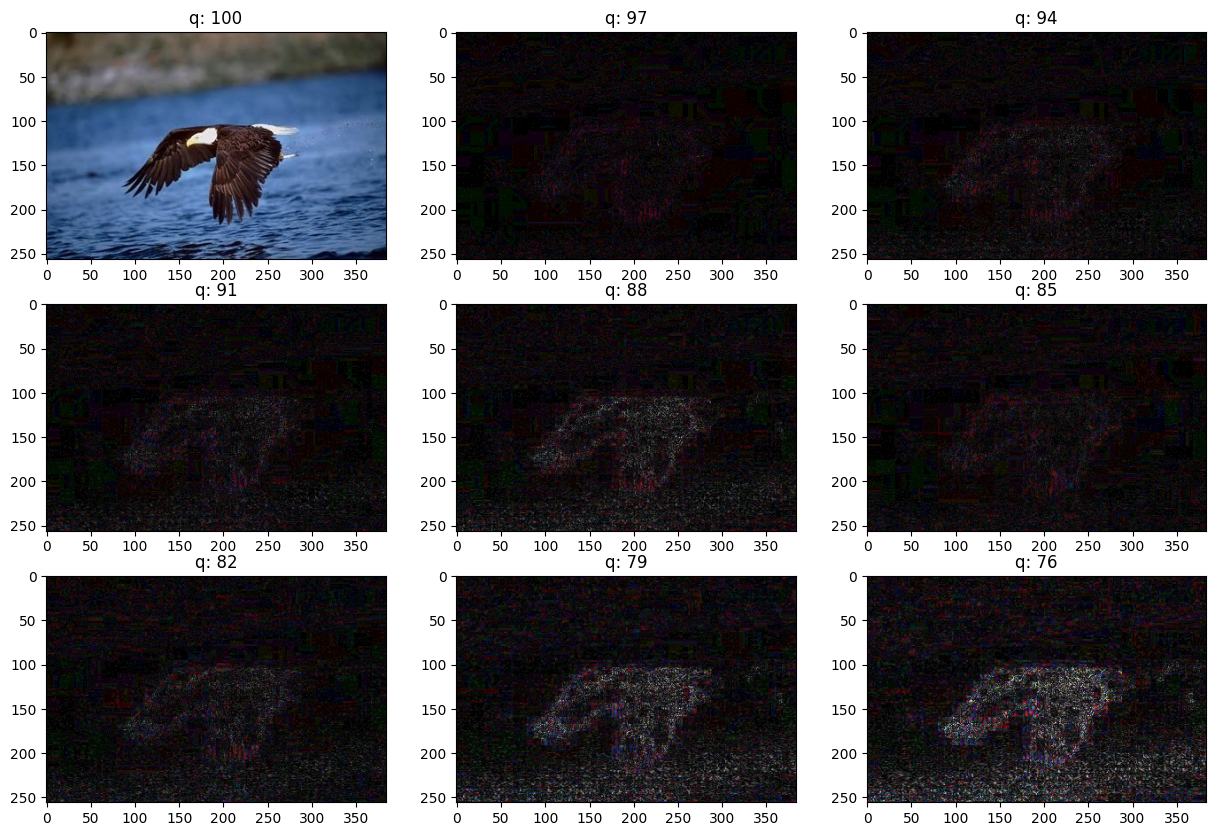

In [28]:
CASIA2 = "/kaggle/input/casiav2revised/CASIA2.0_revised"
p = join(CASIA2, 'Au/')

p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

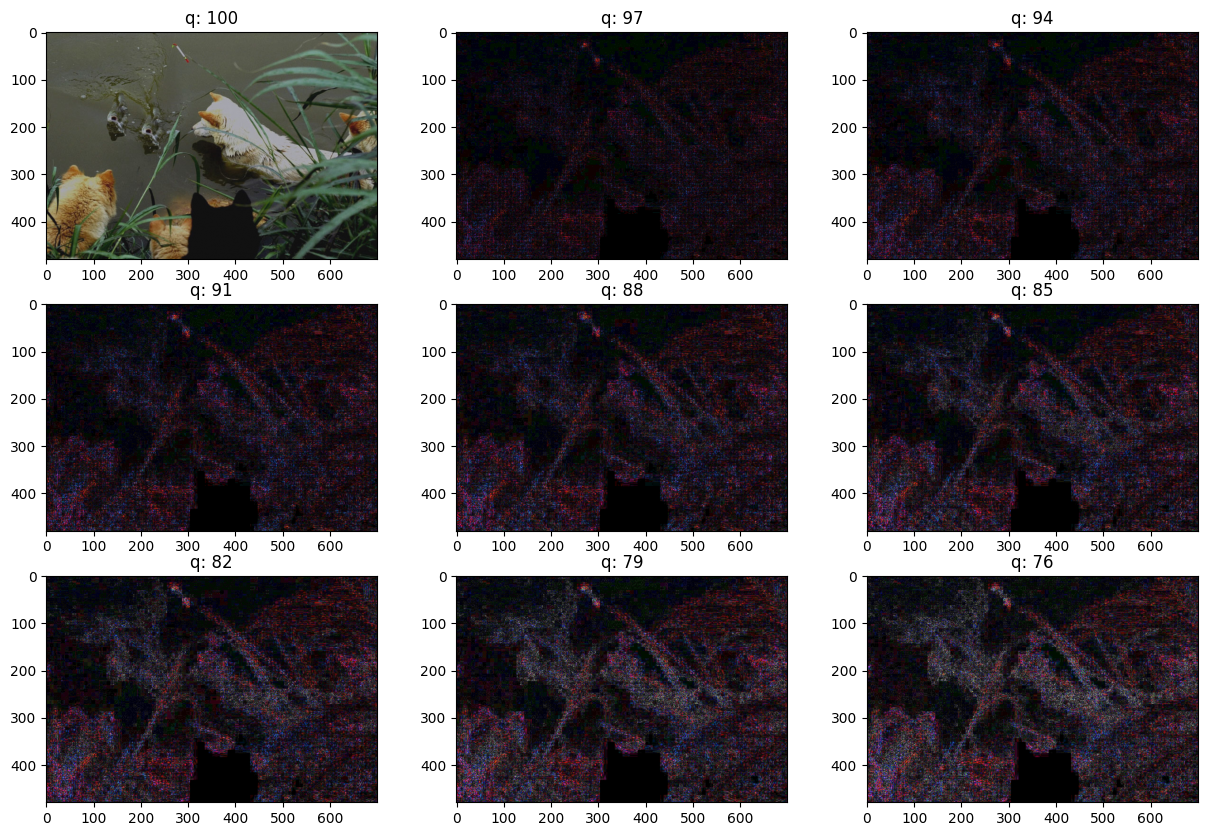

In [29]:
p = join(CASIA2, 'Tp/')
p = random_sample(p)
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 3
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [30]:
image_size=(128,128)
def prepare_image(image_path):
    # Convert the image to ELA image
    ela_image = convert_to_ela_image(image_path, 91)
    resized_ela_image = ela_image.resize(image_size)
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    return image


In [31]:
X = []
Y = [] 
import random
path = '/kaggle/input/casiav2revised/CASIA2.0_revised/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('bmp'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:12000]
Y = Y[:12000]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
7491 7491


In [32]:
path = '/kaggle/input/casiav2revised/CASIA2.0_revised/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 7500 images
Processing 8000 images
Processing 8500 images
Processing 9000 images
Processing 9500 images
Processing 10000 images
Processing 10500 images
Processing 11000 images
Processing 11500 images
Processing 12000 images
Processing 12500 images
12614 12614


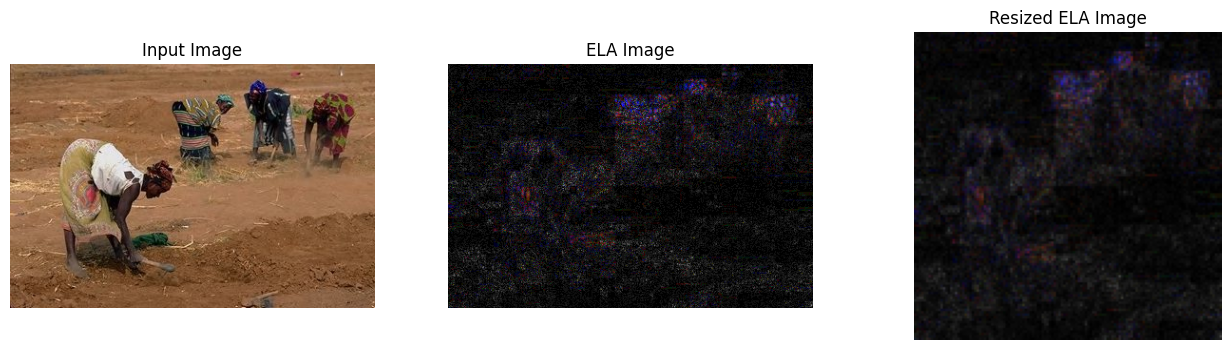

In [42]:
def prepare_image(image_path):
   
    original_image = Image.open(image_path)
    ela_image = convert_to_ela_image(image_path, 91)
    resized_ela_image = ela_image.resize(image_size)
    image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
    return original_image, image

# Example usage
image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Au/Au_cha_00001.jpg"
original_image, image = prepare_image(image_path)
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(convert_to_ela_image(image_path, 91))
plt.title("ELA Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(convert_to_ela_image(image_path, 91).resize(image_size))
plt.title("Resized ELA Image")
plt.axis('off')

plt.show()

In [34]:
# def prepare_image(image_path):
#     # Load the original image
#     original_image = Image.open(image_path)
    
#     # Convert the image to ELA image
#     ela_image = convert_to_ela_image(image_path, 91)
    
#     # Resize the ELA image
#     resized_ela_image = ela_image.resize(image_size)
    
#     # Convert the resized ELA image to a NumPy array and normalize
#     image = np.array(resized_ela_image).astype(np.float32) / 255.0
    
#     # Add noise residuals using the SRM technique
#     srm_residuals = compute_srm_residuals(image)
#     image_with_srm = image + srm_residuals
    
#     return original_image, image_with_srm

# # Example usage
# image_path = "/kaggle/input/casiav2revised/CASIA2.0_revised/Tp/Tp_S_NRN_S_B_cha20001_cha20001_01504.tif"
# original_image, image_with_srm = prepare_image(image_path)

# # Display the original, ELA, and processed images
# plt.figure(figsize=(16, 4))
# plt.subplot(1, 4, 1)
# plt.imshow(original_image)
# plt.title("Input Image")
# plt.axis('off')

# plt.subplot(1, 4, 2)
# plt.imshow(convert_to_ela_image(image_path, 91))
# plt.title("ELA Image")
# plt.axis('off')

# plt.subplot(1, 4, 3)
# plt.imshow(convert_to_ela_image(image_path, 91).resize(image_size))
# plt.title("Resized ELA Image")
# plt.axis('off')

# plt.subplot(1, 4, 4)
# plt.imshow(image_with_srm)
# plt.title("Image with SRM Noise")
# plt.axis('off')
# plt.show()

In [35]:
X = np.array(X)
Y = np.array(Y)


In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

10091 10091
2523 2523


In [37]:
Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)


In [38]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_base.layers[:-4]:
    layer.trainable = False
x = Flatten()(vgg19_base.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg19_base.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history_19 = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, batch_size=32)

# Evaluate the model
loss_19, accuracy_19 = model.evaluate(X_val, Y_val)

# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predictions to class labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_val_labels = np.argmax(Y_val, axis=1)

# Calculate precision, recall, and F1 score
precision_19 = precision_score(Y_val_labels, Y_pred_labels, average='weighted')
recall_19 = recall_score(Y_val_labels, Y_pred_labels, average='weighted')
f1_19 = f1_score(Y_val_labels, Y_pred_labels, average='weighted')

print("Validation Loss:", loss_19)
print("Validation Accuracy:", accuracy_19)
print("Precision:", precision_19)
print("Recall:", recall_19)
print("F1 Score:", f1_19)
model.save("VGG19.h5")

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           51

 Total params: 22,122,306 (84.39 MB)

 Trainable params: 9,177,346 (35.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.7770 - loss: 0.4542 - val_accuracy: 0.8426 - val_loss: 0.3594
Epoch 2/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8486 - loss: 0.3571 - val_accuracy: 0.8312 - val_loss: 0.3720
Epoch 3/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.8639 - loss: 0.3253 - val_accuracy: 0.8522 - val_loss: 0.3409
Epoch 4/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8711 - loss: 0.3074 - val_accuracy: 0.8490 - val_loss: 0.3546
Epoch 5/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8763 - loss: 0.2914 - val_accuracy: 0.8625 - val_loss: 0.3300
Epoch 6/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8857 - loss: 0.2697 - val_accuracy: 0.8197 - val_loss: 0.4034
Epoch 7/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.8881 - loss: 0.2653 - val_accuracy: 0.8585 - val_loss: 0.3369
Epoch 8/30
316/316 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.9033 - loss: 0.2373 - 

In [43]:
# import matplotlib.pyplot as plt

# # Data for VGG19 accuracy over epochs
# epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
# train_acc_19 = history_19.history['accuracy']
# test_acc_19 = history_19.history['val_accuracy']

# # Plotting the line graph for VGG19
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_acc_19, label='VGG19 Training')
# plt.plot(epochs, test_acc_19, label='VGG19 Testing')
# plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
# plt.title('Training and Testing Accuracy of VGG19 Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.text(50, train_acc_19[49], f'{train_acc_19[49]:.2f}', ha='center', va='bottom')
# plt.text(50, test_acc_19[49], f'{test_acc_19[49]:.2f}', ha='center', va='bottom')

# plt.grid(True)
# plt.show()

In [44]:
# import matplotlib.pyplot as plt

# # Data for VGG19 accuracy over epochs
# epochs = range(1, 51)  # Assuming you trained the model for 50 epochs
# train_acc_19 = history_19.history['accuracy']
# test_acc_19 = history_19.history['val_accuracy']

# # Plotting the line graph for VGG19
# plt.figure(figsize=(12, 6))
# plt.plot(epochs, train_acc_19, label='VGG19 Training')
# plt.plot(epochs, test_acc_19, label='VGG19 Testing')
# plt.ylim(0.80, 1.0)  # Set the y-axis limits from 0.80 to 1.0
# plt.title('Training and Testing Accuracy of VGG19 Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.grid(True)
# plt.show()